In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
import os
import mech_io
from pathlib import Path
%matplotlib inline

In [3]:
db = Path(os.path.abspath('')) / "data" / "database" / "2021-05-31_mech_db_clean.db"

In [4]:
yearly_query = """
    /* keycap group buy yearly aggregate stats */
    SELECT
        ydata.*,
        num_icodes
    FROM (
        SELECT --this derived table calculates most rows
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(tdata.topic_id) as num_gbs,
            COUNT(DISTINCT creator_id) as num_creators,
            CAST(AVG(views) as INT) as avg_views,
            MAX(views) as max_views,
            CAST(AVG(replies) as INT) as avg_replies,
            MAX(replies) as max_replies,
            COUNT(CASE WHEN num_posts >= 25 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_25_posts,
            COUNT(CASE WHEN num_posts >= 50 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_50_posts,
            AVG(IFNULL(ldata.num_links, 0)) as avg_links
        --average time for gbs reaching 25/50 posts
        FROM topic_data as tdata
        LEFT JOIN (
            SELECT
                topic_id,
                COUNT(id) as num_links
            FROM topic_link
            GROUP BY topic_id
            ) ldata
        ON tdata.topic_id = ldata.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) ydata
    JOIN (
        SELECT --this derived table calculates number of infocodes used
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(DISTINCT icode.info_code) as num_icodes
        FROM topic_data as itdata
        JOIN topic_icode as icode
            ON itdata.topic_id = icode.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) iydata
    ON ydata.gb_year = iydata.gb_year
    ORDER BY gb_year;
    """

post50_query = """
    /* keycap group buy time interval stats (aggregate in python)
        - pulls topic level post_50_delta stats
        - sqlite doesn't support time intervals */
    SELECT
        topic_id,
        STRFTIME('%Y', topic_created) as gb_year,
        post_50_delta
    FROM topic_data
    WHERE product_type = 'keycaps'
            AND board_id = '70'
    ORDER BY gb_year, topic_id
    """

# connect to database and pull data
conn = sqlite3.connect(db)
yearly_df = pd.read_sql_query(yearly_query, conn, index_col="gb_year")
post50_df = pd.read_sql_query(post50_query, conn, index_col="topic_id")
conn.close()

In [5]:
# parse post_50_delta to extract day (sqlite doesn't support time intervals)
post50_df['post_50_day'] = post50_df['post_50_delta'].apply(lambda x: mech_io.db_parse_td_str(x)['days'])

# filter topics to find topics reaching 50 posts within 30 days
pop_post_df = post50_df[post50_df['post_50_day'] < 30][['gb_year', 'post_50_day']]

# aggregate across years and calculate percent
post_th_df = pop_post_df.groupby(['gb_year']).count()
post_th_df.rename(columns={'post_50_day':'count_post_th'}, inplace=True)
post_th_df['pct_post_th'] = post_th_df['count_post_th'] * 100 / yearly_df['num_gbs']

# join aggregated data with other yearly data
yearly_df = yearly_df.join(post_th_df)
yearly_df.reset_index(inplace=True)

In [6]:
yearly_df.head(10)

,gb_year,num_gbs,num_creators,avg_views,max_views,avg_replies,max_replies,percent_25_posts,percent_50_posts,avg_links,num_icodes,count_post_th,pct_post_th
0,2012,6,3,28148,123953,146,687,66.666667,50.000000,0.500000,1,3,50.000000
1,2013,19,10,273925,1600608,795,2537,94.736842,89.473684,1.684211,6,16,84.210526
2,2014,11,6,347062,2001068,833,2305,100.000000,90.909091,1.909091,3,10,90.909091
3,2015,16,12,923409,9396954,1320,5922,100.000000,100.000000,2.812500,6,14,87.500000
4,2016,24,20,133977,767197,319,1076,95.833333,83.333333,2.833333,8,16,66.666667
5,2017,38,31,28367,156940,134,885,78.947368,63.157895,3.394737,5,14,36.842105
6,2018,48,39,45693,139646,211,658,97.916667,81.250000,5.354167,8,26,54.166667
7,2019,90,64,62893,199214,154,841,84.444444,70.000000,5.122222,13,36,40.000000
8,2020,148,107,31307,95061,67,243,82.432432,56.756757,9.432432,13,44,29.729730
9,2021,82,76,10996,32540,33,103,64.634146,24.390244,12.987805,11,8,9.756098


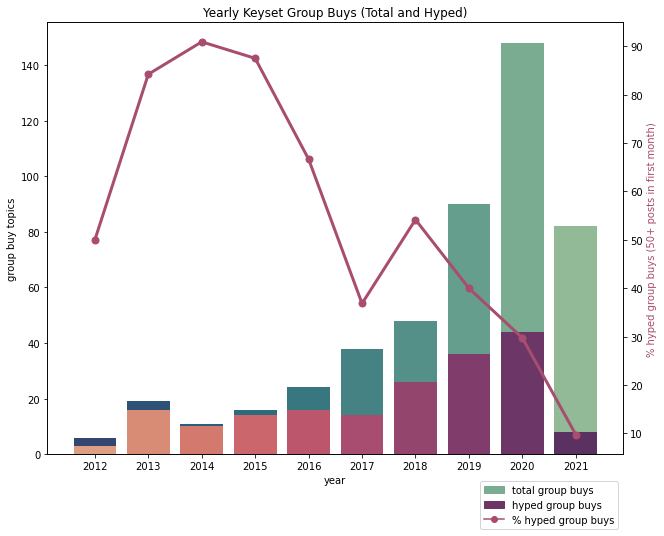

In [23]:
# create plot and set up twin axis
yearly_plot = plt.figure(figsize=[8,6])
yearly_ax1 = yearly_plot.add_axes([1, 1, 1, 1])
yearly_ax2 = yearly_ax1.twinx()

# plot total gbs, "popular" gbs, and % popular gbs
sns.barplot(data=yearly_df, x='gb_year', y='num_gbs', palette='crest_r', ax=yearly_ax1)
sns.barplot(data=yearly_df, x='gb_year', y='count_post_th', palette='flare', ax=yearly_ax1)
yearly_ax2.plot(yearly_df['gb_year'], yearly_df['pct_post_th'], 
                marker='o', linewidth=3, markersize=7, color='#A84D6F')

# add axis labels/legend
yearly_ax1.set_title("Yearly Keyset Group Buys (Total and Hyped)")
yearly_ax1.set_xlabel('year')
yearly_ax1.set_ylabel('group buy topics')
yearly_ax2.set_ylabel('% hyped group buys (50+ posts in first month)', color='#A84D6F')
gb_patch = mpatches.Patch(color='#7AAC91', label='total group buys')
pop_patch = mpatches.Patch(color='#6C3667', label='hyped group buys')
pct_patch = mlines.Line2D([], [], color='#A84D6F', marker='o', label='% hyped group buys')
plt.legend(handles=[gb_patch, pop_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')


In this graph, even though the number of group buys shows a massive increase year over year - the average number of replies has consistently decreased.
Partially this can be explained by a larger number of "chaff" gbs that fail to go into production - but the larger part of the story is probably moving from purchasing happening on the forum itself to purchases at spcific regional vendors and proxies (so the change in average replies represents the geekhack threads being used more as an archive or hub vs a place for actual discussion and purchases).

In [19]:
monthly2020_query = """SELECT strftime('%m %Y', topic_created) AS month, 
                         COUNT('td.topic_id') AS 'group buys', 
                         AVG(views), 
                         AVG(replies)
                  FROM topic_data AS td LEFT JOIN topic_advanced AS ta
                      ON td.topic_id = ta.topic_id
                  WHERE product_type = 'keycaps' AND board = '70' 
                      AND (strftime('%Y', topic_created) IN ('2017', '2018', '2019', '2020'))
                  GROUP BY strftime('%Y %m', topic_created)
                  ;"""

conn = sqlite3.connect(db)
monthly2020_df = pd.read_sql_query(monthly2020_query, conn)
conn.close()

In [20]:
monthly2020_df.head()

,month,group buys,AVG(views),AVG(replies)
0,01 2017,2,117776.000000,715.500000
1,02 2017,3,24146.333333,117.333333
2,03 2017,4,18398.250000,85.750000
3,04 2017,2,11969.500000,62.500000
4,05 2017,2,11155.500000,29.500000


In [34]:
monthly_rolling = monthly2020_df['group buys'].rolling(3).mean()
monthly_rolling.head()

0         NaN
1         NaN
2    3.000000
3    3.000000
4    2.666667
Name: group buys, dtype: float64

<AxesSubplot:ylabel='group buys'>

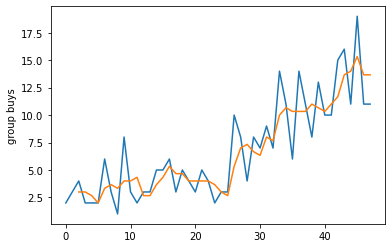

In [35]:
monthly2020_plot, monthly2020_ax1 = plt.subplots()
sns.lineplot(data=monthly2020_df['group buys'], palette='mako', ax=monthly2020_ax1)
sns.lineplot(data=monthly_rolling, palette='mako', ax=monthly2020_ax1)
# sns.regplot(x=monthly2020_df.index, y=monthly2020_df['group buys'], order=2, ax=monthly2020_ax1)
# plot two different linear regressions based on the year?

In [37]:
gbvsic_query = """SELECT gb.topic_id as 'group buy',
                     ic.topic_id as 'interest check',
                     gb.set_name as 'set name',
                     gb.views as 'group buy views',
                     ic.views as 'interest check views',
                     gb.replies as 'group buy replies',
                     ic.replies as 'interest check replies',
                     strftime('%Y', ta.topic_created) as 'group buy year'
              FROM topic_data AS gb INNER JOIN topic_data AS ic
                  ON gb.set_name = ic.set_name
                  AND gb.board = '70'
                  AND ic.board = '132'
              LEFT JOIN topic_advanced AS ta
                      ON gb.topic_id = ta.topic_id
              WHERE gb.product_type = 'keycaps'
              ;"""

conn = sqlite3.connect(db)
gbvsic_df = pd.read_sql_query(gbvsic_query, conn)
conn.close()

In [38]:
gbvsic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   group buy               305 non-null    object
 1   interest check          305 non-null    object
 2   set name                305 non-null    object
 3   group buy views         305 non-null    int64 
 4   interest check views    305 non-null    int64 
 5   group buy replies       305 non-null    int64 
 6   interest check replies  305 non-null    int64 
 7   group buy year          305 non-null    object
dtypes: int64(4), object(4)
memory usage: 19.2+ KB


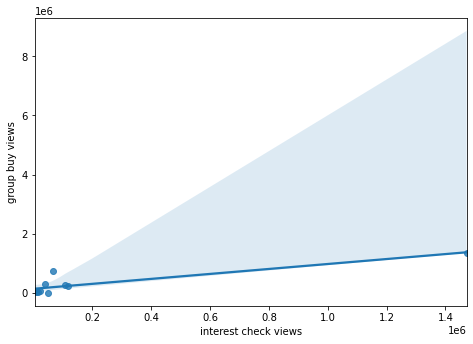

In [39]:
gbvsic_plot = plt.figure()
gbvsic_ax1 = gbvsic_plot.add_axes([1, 1, 1, 1])
sns.regplot(data=gbvsic_df[gbvsic_df['group buy year'].isin(['2012', '2013', '2014', '2015'])], x='interest check views', y='group buy views', ax=gbvsic_ax1)
# gbvsic_ax1.set_xlim(xmin= 0, xmax=200000)
# gbvsic_ax1.set_ylim(ymin = 0, ymax=200000)

ModuleNotFoundError: No module named 'statsmodels'

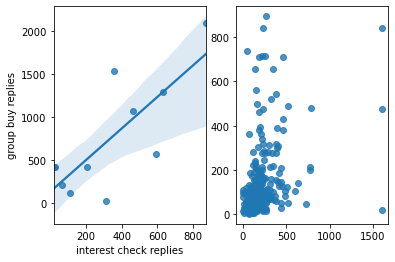

In [42]:
gbvsic2_plot, (gbvsic2_ax1, gbvsic2_ax2) = plt.subplots(1, 2)
# gbvsic2_ax1 = gbvsic2_plot.add_axes([1, 1, 1, 1])
sns.regplot(data=gbvsic_df[gbvsic_df['group buy year'].isin(['2012', '2013', '2014', '2015'])], x='interest check replies', y='group buy replies', ax=gbvsic2_ax1)
# gbvsic2_ax1.set_xlim(xmin= 0, xmax=750)
# gbvsic2_ax1.set_ylim(ymin = 0, ymax=750)
sns.regplot(data=gbvsic_df[gbvsic_df['group buy year'].isin(['2016', '2017', '2018', '2019', '2020', '2021'])], x='interest check replies', y='group buy replies', robust=True, ax=gbvsic2_ax2)